In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import SelectFromModel
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [141]:
import keras as K
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg
from keras.optimizers import SGD

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [79]:
trainF = pd.read_csv('./data/train.csv')
trainF2 = pd.read_csv('./data/train_2.csv')
predF = pd.read_csv('./data/test.csv')

In [80]:
trainF['L1']=0
trainF['L2']=0

for i in range(trainF.shape[0]):
    penalty = trainF['penalty'].values[i]
    l1_ratio = trainF['l1_ratio'].values[i]
    if type(penalty) == int:
        continue
    elif 'elasticnet' in penalty:
        trainF.loc[i,['L1']]=l1_ratio
        trainF.loc[i,['L2']]=1-l1_ratio
    elif 'l1' in penalty:
        trainF.loc[i,['L1']]=1
    elif 'l2' in penalty:
        trainF.loc[i,['L2']]=1

In [81]:
trainF2['L1']=0
trainF2['L2']=0

for i in range(trainF2.shape[0]):
    penalty = trainF2['penalty'].values[i]
    l1_ratio = trainF2['l1_ratio'].values[i]
    if type(penalty) == int:
        continue
    elif 'elasticnet' in penalty:
        trainF2.loc[i,['L1']]=l1_ratio
        trainF2.loc[i,['L2']]=1-l1_ratio
    elif 'l1' in penalty:
        trainF2.loc[i,['L1']]=1
    elif 'l2' in penalty:
        trainF2.loc[i,['L2']]=1

In [82]:
predF['L1']=0
predF['L2']=0

for i in range(predF.shape[0]):
    penalty = predF['penalty'].values[i]
    l1_ratio = predF['l1_ratio'].values[i]
    if type(penalty) == int:
        continue
    elif 'elasticnet' in penalty:
        predF.loc[i,['L1']]=l1_ratio
        predF.loc[i,['L2']]=1-l1_ratio
    elif 'l1' in penalty:
        predF.loc[i,['L1']]=1
    elif 'l2' in penalty:
        predF.loc[i,['L2']]=1

In [83]:
trainF = pd.concat([trainF, trainF2], axis=0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [84]:
data = pd.concat([trainF, predF], axis=0)
trainlen = len(trainF)
predlen = len(predF)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [85]:
data.loc[:, ['penalty']] = np.array(pd.Series(data['penalty'].values).replace('elasticnet', 2)).reshape(-1,1)
data.loc[:, ['penalty']] = np.array(pd.Series(data['penalty'].values).replace('none', 0)).reshape(-1,1)
data.loc[:, ['penalty']] = np.array(pd.Series(data['penalty'].values).replace('l1', 1)).reshape(-1,1)
data.loc[:, ['penalty']] = np.array(pd.Series(data['penalty'].values).replace('l2', 3)).reshape(-1,1)

data.loc[:, ['n_jobs']] = np.array(pd.Series(data['n_jobs'].values).replace(-1, 16)).reshape(-1,1)

In [86]:
data.drop(['random_state'],1, inplace=True)
data.drop(['id'],1, inplace=True)

In [77]:
# data.iloc[:trainlen,:].corr()

In [88]:
# data

In [89]:
data_normalized = preprocessing.normalize(data.iloc[:,:-1], norm='l2')
min_max_scaler = preprocessing.MinMaxScaler()
data_mm_scal = min_max_scaler.fit_transform(data_normalized)

# data['flip_y_normmm']=data_mm_scal[:,3]#data_mm_scal[:,1]
data['l1_ratio_normmm']=data_mm_scal[:,4]
# data['n_classes_normmm']=data_mm_scal[:,6]#data_mm_scal[:,4]
# data['n_clusters_per_class_normmm']=data_mm_scal[:,8]#data_mm_scal[:,5]
data['n_informative_normmm']=data_mm_scal[:,9]#data_mm_scal[:,7]
data['n_jobs_normmm']=data_mm_scal[:,10]#data_mm_scal[:,8]
# data['penalty_normmm']=data_mm_scal[:,12]#data_mm_scal[:,10]
data['scale_normm']=data_mm_scal[:,14]#data_mm_scal[:,11]

In [90]:
# from matplotlib import pyplot as plt

# for f in data.columns.values:
#     print(f)
#     X = data[f].values[:trainlen]
#     y = trainL
#     plt.scatter(X,y)
#     plt.savefig(f+"_norm + mm_scal"+".jpg")
#     plt.show()

In [144]:
def OneHotEnc(data, features_cate, generate):
#     dataset = pd.concat([data[features_all], data[generate]], axis=1)
    dataset = pd.concat([data, data[generate]], axis=1)
    
    for feature in features_cate+generate:
        df = pd.get_dummies(data[feature], prefix=feature)
        dataset = pd.concat([dataset, df], axis=1)
        
    return dataset

dataset = OneHotEnc(data, ['penalty'], []) #'alpha'

# dataset = pd.DataFrame()
# dataset = data.iloc[:,:]

In [304]:
# temp = dataset.iloc[400:440, :]

# temp.corr()['time']

# explore_col = ['L1', 'L2', 'alpha', 'flip_y', 'max_iter', 'n_classes',
#        'n_clusters_per_class', 'n_features', 'n_informative', 'n_jobs',
#        'n_samples', 'penalty', 'scale', 'l1_ratio_normmm',
#        'n_informative_normmm', 'n_jobs_normmm', 'scale_normm',
#        'penalty_0', 'penalty_1', 'penalty_2', 'penalty_3']

# factor_2 = []

# newf_num = 1

# for f1 in explore_col:
#     for f2 in explore_col[explore_col.index(f1):]:
        
#         temp['cf'+str(newf_num)] = temp[f1]*temp[f2]
#         pearson = temp.corr()['time']['cf'+str(newf_num)]
#         if pearson > 0.4:
#             factor_2.append(['cf'+str(newf_num),f1,f2,pearson])
#             newf_num += 1
#             print(f1,'*',f2,':',pearson)
#         else:
#             temp.drop('cf'+str(newf_num),1,inplace=True)

# print(factor_2)

In [145]:
dataset['cf8']=data['max_iter']*dataset['n_samples']
dataset['cf9']=data['max_iter']*dataset['penalty_2']
dataset['cf11']=data['n_classes']*dataset['penalty_2']
dataset['cf12']=data['n_informative']*dataset['penalty_2']
dataset['cf16']=data['n_samples']*dataset['penalty_2']

In [94]:
# dataset.iloc[:440,:].corr()['time']

Record:<p>
[['cf1', 'L1', 'L2', 0.4454852138309251], ['cf2', 'L2', 'penalty_2', 0.4703546077393542], ['cf3', 'alpha', 'n_samples', 0.4566856545656562], ['cf4', 'alpha', 'penalty_2', 0.5334197498449157], ['cf5', 'flip_y', 'n_samples', 0.4009361530828913], ['cf6', 'flip_y', 'penalty_2', 0.6040425184400429], ['cf7', 'max_iter', 'n_classes', 0.484374989718596], ['cf8', 'max_iter', 'n_samples', 0.6222014199034712], ['cf9', 'max_iter', 'penalty_2', 0.5683625312020067], ['cf10', 'n_classes', 'n_samples', 0.4277177967509479], ['cf11', 'n_classes', 'penalty_2', 0.6229716447297312], ['cf12', 'n_features', 'penalty_2', 0.4014408065457138], ['cf13', 'n_informative', 'n_samples', 0.48367061753557655], ['cf14', 'n_informative', 'penalty_2', 0.5169822963572361], ['cf15', 'n_samples', 'n_samples', 0.4136628567243141], ['cf16', 'n_samples', 'penalty_2', 0.6759662894171211], ['cf17', 'penalty', 'penalty_2', 0.4327137523259015], ['cf18', 'scale', 'penalty_2', 0.5077675768883818], ['cf19', 'scale_normm', 'penalty_2', 0.4264815070143489], ['cf20', 'penalty_2', 'penalty_2', 0.4327137523259015]]


In [95]:
# factor_d = []

# newf_num = 21

# for f1 in explore_col+['cf8','cf9','cf11','cf12','cf16']:
        
#         temp['cf'+str(newf_num)] = temp[f1]/(np.log2(temp['n_jobs'])+1)
#         pearson = temp.corr()['time']['cf'+str(newf_num)]
#         if pearson > 0.4:
#             factor_d.append(['cf'+str(newf_num),f1,pearson])
#             newf_num += 1
#             print(f1,':',pearson)
#         else:
#             temp.drop('cf'+str(newf_num),1,inplace=True)

# print(factor_d)

In [146]:
dataset['cf22']=data['flip_y']/(data['n_jobs'])#/(np.log2(data['n_jobs'])+1)
dataset['cf23']=data['max_iter']/(np.log2(data['n_jobs'])+1)
dataset['cf24']=data['n_classes']/(data['n_jobs'])#/(np.log2(data['n_jobs'])+1)
dataset['cf25']=data['n_informative']/(data['n_jobs'])#/(np.log2(data['n_jobs'])+1)
dataset['cf26']=data['n_samples']/(np.log2(data['n_jobs'])+1)
dataset['cf28']=dataset['penalty_2']/(data['n_jobs'])#/(np.log2(data['n_jobs'])+1)
dataset['cf29']=dataset['cf8']/(np.log2(data['n_jobs'])+1)
dataset['cf30']=dataset['cf9']/(data['n_jobs'])#/(np.log2(data['n_jobs'])+1)
dataset['cf31']=dataset['cf11']/(data['n_jobs'])#/(np.log2(data['n_jobs'])+1)
dataset['cf32']=dataset['cf12']/(data['n_jobs'])#/(np.log2(data['n_jobs'])+1)
dataset['cf33']=dataset['cf16']/(data['n_jobs'])#/(np.log2(data['n_jobs'])+1)

In [99]:
# dataset.iloc[:,:].corr()['time']

In [100]:
# factor_3 = []

# newf_num = 34

# for f1 in ['cf8','cf9','cf11','cf12','cf16']:
#      for f2 in ['max_iter','n_classes','penalty_2','n_informative','n_samples']:
#         temp['cf'+str(newf_num)] = temp[f1]*temp[f2]
#         pearson = temp.corr()['time']['cf'+str(newf_num)]
#         if pearson > 0.4:
#             factor_3.append(['cf'+str(newf_num),f1,f2,pearson])
#             newf_num += 1
#             print(f1,'*',f2,':',pearson)
#         else:
#             temp.drop('cf'+str(newf_num),1,inplace=True)

# print(factor_3)

Record:<p>
 ['cf8', 'max_iter', 'n_samples', 0.6222014199034712], <p>
    ['cf9', 'max_iter', 'penalty_2', 0.5683625312020067], <p>
            ['cf11', 'n_classes', 'penalty_2', 0.6229716447297312], <p>
                ['cf12', 'n_features', 'penalty_2', 0.4014408065457138], <p>
                    
['cf16', 'n_samples', 'penalty_2', 0.6759662894171211],

In [147]:
dataset['cf35']=dataset['cf8']*data['n_classes']
dataset['cf37']=dataset['cf8']*data['n_informative']

dataset['cf40']=dataset['cf9']*data['n_classes']
dataset['cf41']=dataset['cf9']*data['n_informative']

dataset['cf45']=dataset['cf11']*data['n_informative']
dataset['cf46']=dataset['cf11']*data['n_samples']
dataset['cf47']=dataset['cf12']*data['max_iter']
dataset['cf48']=dataset['cf12']*data['n_classes']

dataset['cf51']=dataset['cf12']*data['n_samples']
dataset['cf54']=dataset['cf16']*data['n_informative']
dataset['cf55']=dataset['cf16']*data['n_samples']

In [138]:
# dataset.iloc[:,:].corr()['time']

In [148]:
#构造特征只保留0.4以上的
dataset.drop(['cf9','cf11','cf12','cf16','cf25','cf40','cf41','cf45','cf47','cf48','cf55'],1,inplace=True)

In [149]:
dataset.drop(['L2', 'l1_ratio', 'alpha', 'flip_y', 'n_clusters_per_class', 'scale', 'penalty'],1, inplace=True)

In [150]:
dataset.columns

Index(['L1', 'max_iter', 'n_classes', 'n_features', 'n_informative', 'n_jobs',
       'n_samples', 'random_state', 'time', 'l1_ratio_normmm',
       'n_informative_normmm', 'n_jobs_normmm', 'scale_normm', 'penalty_0',
       'penalty_1', 'penalty_2', 'penalty_3', 'cf8', 'cf22', 'cf23', 'cf24',
       'cf26', 'cf28', 'cf29', 'cf30', 'cf31', 'cf32', 'cf33', 'cf35', 'cf37',
       'cf46', 'cf51', 'cf54'],
      dtype='object')

In [151]:
dataset.head()

,L1,max_iter,n_classes,n_features,n_informative,n_jobs,n_samples,random_state,time,l1_ratio_normmm,...,cf29,cf30,cf31,cf32,cf33,cf35,cf37,cf46,cf51,cf54
0,0.000000,417,4,327,7,16,1089,475,0.409987,0.066057,...,90822.600000,0.0,0.0,0.0,0.0,1816452,3178791,0,0,0
1,1.000000,578,4,373,7,1,790,569,3.950953,0.196734,...,456620.000000,0.0,0.0,0.0,0.0,1826480,3196340,0,0,0
2,0.000000,588,2,1198,6,2,428,529,0.368702,0.157845,...,125832.000000,0.0,0.0,0.0,0.0,503328,1509984,0,0,0
3,0.000000,829,6,313,7,4,877,103,1.004559,0.116388,...,242344.333333,0.0,0.0,0.0,0.0,4362198,5089231,0,0,0
4,0.395049,167,8,644,11,2,216,418,0.802800,0.152129,...,18036.000000,83.5,4.0,5.5,108.0,288576,396792,1728,2376,2376


In [152]:
# data_scaled = preprocessing.scale(data.iloc[:,:14])
min_max_scaler = preprocessing.MinMaxScaler()
data_scaled_mm = min_max_scaler.fit_transform(dataset.iloc[:,:8])

dataset['max_iter']=data_scaled_mm[:,1]
dataset['n_classes']=data_scaled_mm[:,2]
# dataset['n_clusters_per_class']=data_scaled_mm[:,3]
dataset['n_features']=data_scaled_mm[:,3]
dataset['n_informative']=data_scaled_mm[:,4]
dataset['n_jobs']=data_scaled_mm[:,5]
dataset['n_samples']=data_scaled_mm[:,6]
dataset['penalty']=data_scaled_mm[:,7]

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [153]:
data_scaled_mm = min_max_scaler.fit_transform(dataset.iloc[:,-16:])

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [127]:
# data_scaled_mm.shape

In [154]:
dataset['cf8']=data_scaled_mm[:,0]
dataset['cf22']=data_scaled_mm[:,1]
dataset['cf23']=data_scaled_mm[:,2]
dataset['cf24']=data_scaled_mm[:,3]
dataset['cf26']=data_scaled_mm[:,4]
dataset['cf28']=data_scaled_mm[:,5]
dataset['cf29']=data_scaled_mm[:,6]
dataset['cf30']=data_scaled_mm[:,7]
dataset['cf31']=data_scaled_mm[:,8]
dataset['cf32']=data_scaled_mm[:,9]
dataset['cf33']=data_scaled_mm[:,10]
dataset['cf35']=data_scaled_mm[:,11]
dataset['cf37']=data_scaled_mm[:,12]
dataset['cf46']=data_scaled_mm[:,13]
dataset['cf51']=data_scaled_mm[:,14]
dataset['cf54']=data_scaled_mm[:,15]

In [155]:
dataset.shape

(540, 34)

In [156]:
dataset.drop(['random_state'],1, inplace=True)

In [157]:
trainL = dataset['time'][:trainlen]

In [158]:
dataset.drop(['time'],1, inplace=True)

In [159]:
trainset = dataset.iloc[:trainlen, :]
predset = dataset.iloc[trainlen:trainlen+predlen, :]

L1


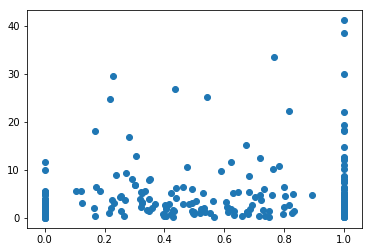

L2


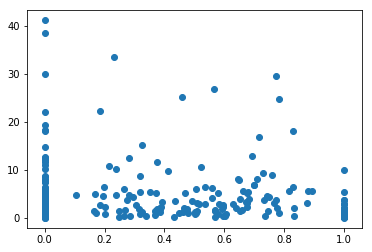

max_iter


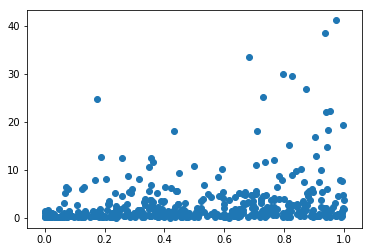

n_classes


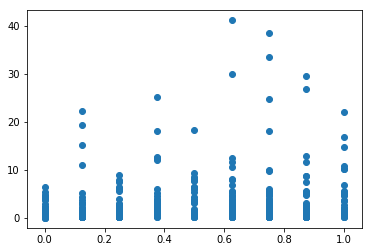

n_clusters_per_class


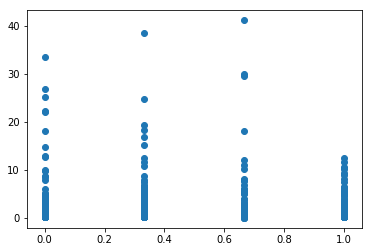

n_features


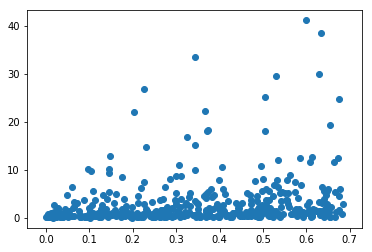

n_informative


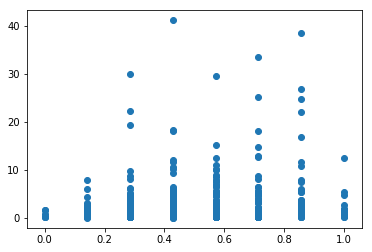

n_jobs


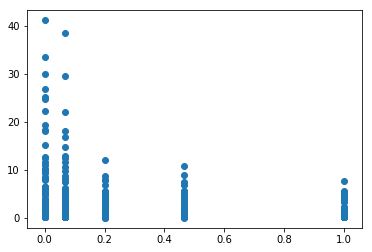

n_samples


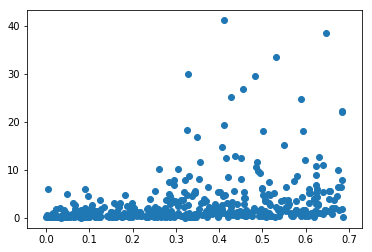

penalty


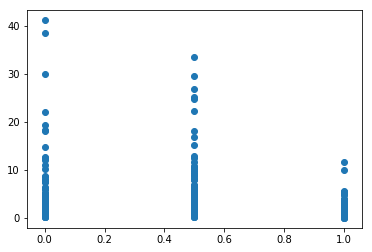

scale


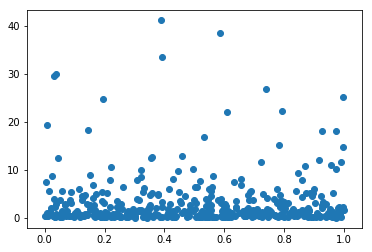

flip_y_normmm


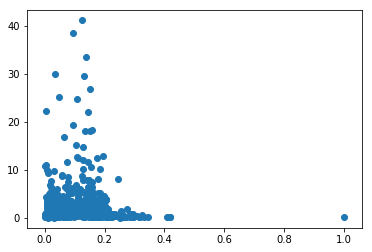

n_classes_normmm


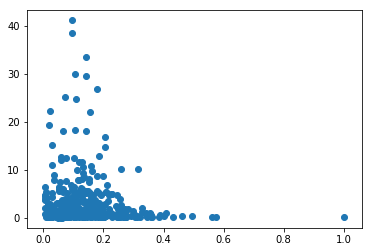

n_clusters_per_class_normmm


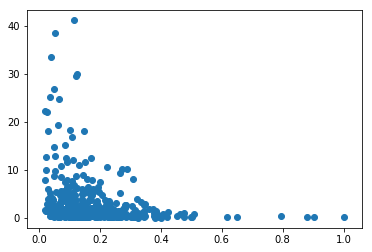

n_informative_normmm


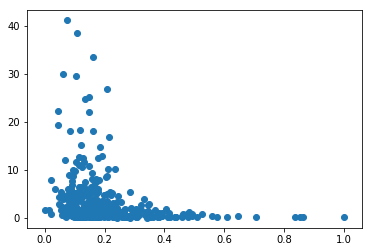

n_jobs_normmm


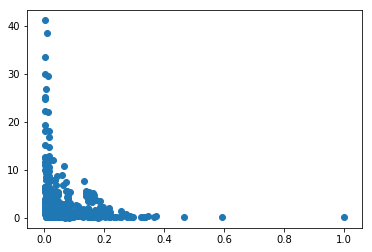

penalty_normmm


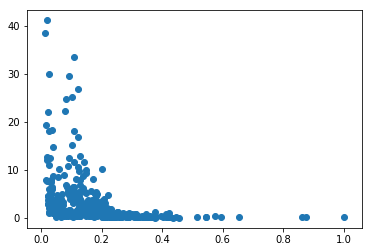

scale_normm


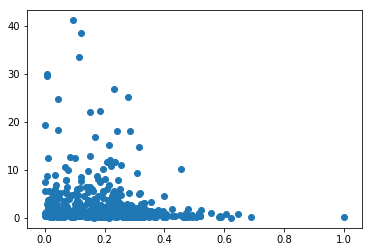

alpha_0.0001


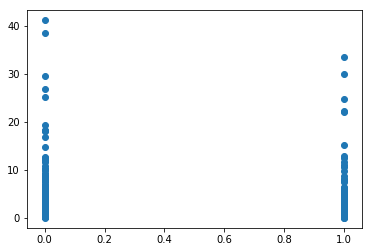

alpha_0.001


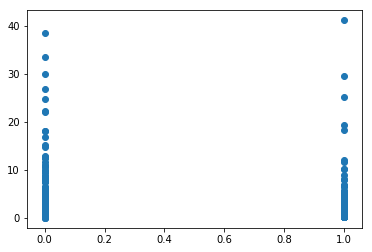

alpha_0.01


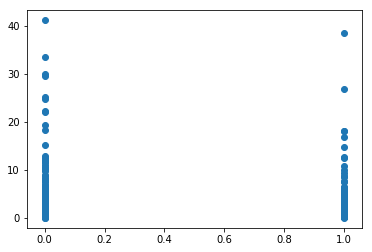

penalty_0.0


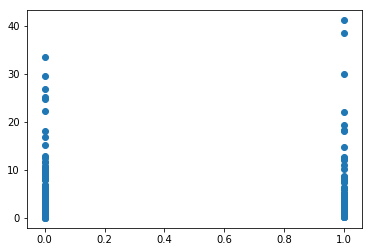

penalty_0.5


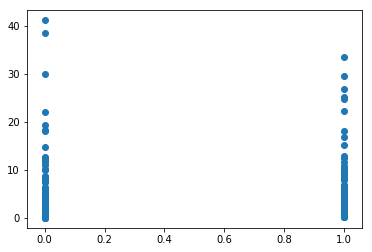

penalty_1.0


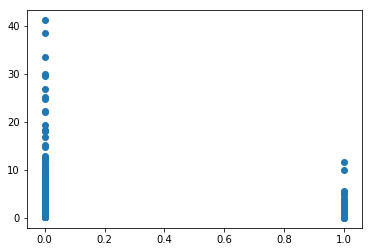

cf1


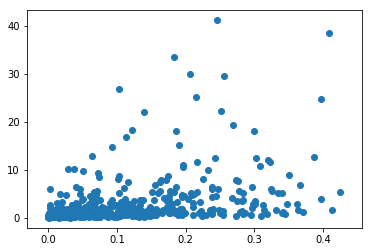

cf2


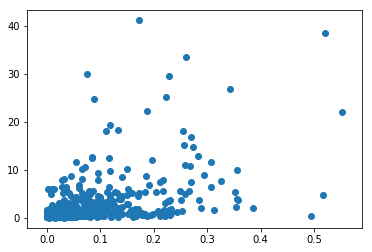

cf4


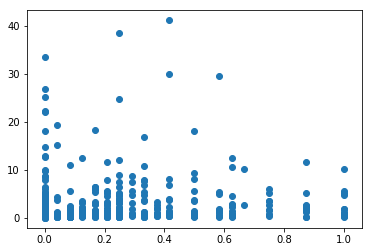

cf5


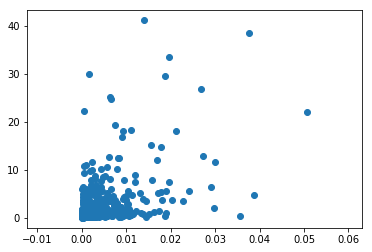

cf3


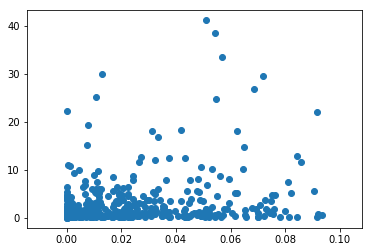

In [157]:
from matplotlib import pyplot as plt

for f in dataset.columns.values:
    print(f)
    X = dataset[f].values[:trainlen]
    y = trainL
    plt.scatter(X,y)
#     plt.savefig(f+"_norm + mm_scal"+".jpg")
    plt.show()

In [76]:
train.columns.values

array(['L1', 'max_iter', 'n_classes', 'n_features', 'n_informative',
       'n_jobs', 'n_samples', 'l1_ratio_normmm', 'n_informative_normmm',
       'n_jobs_normmm', 'scale_normm', 'penalty_0', 'penalty_1',
       'penalty_2', 'penalty_3', 'cf8', 'cf22', 'cf23', 'cf24', 'cf26',
       'cf28', 'cf29', 'cf30', 'cf31', 'cf32', 'cf33', 'cf35', 'cf37',
       'cf46', 'cf51', 'cf54', 'time'], dtype=object)

In [160]:
train = pd.concat([trainset, trainL], axis=1)
train.to_csv("train_31_1122.csv",index=False,sep=',')
predset.to_csv("pred_31_1122.csv",index=False,sep=',')

In [161]:
train = pd.read_csv("train_31_1114520.csv")
predset = pd.read_csv("pred_31_1114520.csv")

In [163]:
# train.columns.values

#前方高能预警

In [ ]:
tuningset = pd.read_csv('drive/5001/1114_05_mean.csv')
tuningset = pd.concat([predset, tuningset['time']],axis=1)
trainset = pd.concat([trainset, tuningset],axis=0)

In [ ]:
predictions=[]
for i in range(20):
    test_size = 0.2
    X_train, X_test, y_train, y_test = train_test_split(trainset, trainL, test_size=test_size, random_state=i)  #np.random.randint(10)

    model = Sequential()
    model.add(Dense(1000,input_dim=X_train.shape[1],activation="relu",name="full_1",kernel_initializer='random_uniform'))
    model.add(Dense(1000,activation="relu",name="full_2"))
    model.add(Dense(2000,activation="relu",name="full_3"))
    model.add(Dense(3000,activation="relu",name="full_4"))
    model.add(Dense(4000,activation="relu",name="full_5"))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation="linear", use_bias=True, bias_initializer='zeros', bias_regularizer='l1_l2', bias_constraint=non_neg()))  #use_bias=True, bias_regularizer='l1_l2'
    # model.summary()

    model.compile(loss='mean_squared_error', optimizer='adam')   #adam
    model_fit = model.fit(X_train, y_train, batch_size=100, epochs=1200, verbose=0) 

    #   score = model.evaluate(x_test, y_test, batch_size=16)
    y_pred = model.predict(X_test)

    MSE = mean_squared_error(y_test, y_pred)
    loss = model_fit.history["loss"][-1]
    # val_loss = model_fit.history["val_loss"][-1]
    print(MSE,loss)

    predictions.append(model.predict(predset))

In [ ]:
res = predictions

In [393]:
# res = pd.read_csv('1118_04_mean.csv')

import csv

with open("submission.csv", "w") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Id'] + ['time'])
    i = 0
    count = 0
    for x in res.mean().values:
        if x < 0:
            count += 1
        else:
            writer.writerow([i] + [x])
        i += 1

print('num of < : ', count)

In [75]:
# train = pd.read_csv("train_31_1114520.csv")
# predset = pd.read_csv("pred_31_1114520.csv")

# train = train.iloc[:trainlen, :]
# trainset = train.values[:,:-1]
# trainL = train.values[:,-1]

In [1]:
# from sklearn.linear_model import LinearRegression

# lr = LinearRegression()

# lr.fit(trainset, trainL)

# prediction = cross_val_predict(lr, trainset, trainL, cv=10)
# print("使用交叉验证的均方误差为:",mean_squared_error(trainL, prediction))

# submit = lr.predict(predset)

# import csv

# with open("submission", "w") as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Id'] + ['time'])
#     i = 0
#     count = 0
#     for x in range(len(submit)):
#         if submit[x] < 0:
#             count += 1
#             if submit[x]<-1:
#                 writer.writerow([i] + [0])
#             else:
#                 writer.writerow([i] + [(1+submit[x])])
#         else:
#             writer.writerow([i] + [submit[x]])
#         i += 1

# print('num of < : ', count)

In [371]:
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import cross_val_predict
# model =GradientBoostingRegressor()

# #Fit the algorithm on the training set
# model.fit(trainset, trainL)
# scores = cross_val_score(model, trainset, trainL.ravel(), cv=10)
# print(" Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
# prediction = cross_val_predict(model, trainset, trainL, cv=10)

# print("使用交叉验证的均方误差为:",mean_squared_error(trainL, prediction))

# model.feature_importances_

In [143]:
# from sklearn.ensemble import RandomForestRegressor
# regr = RandomForestRegressor(max_depth=8, random_state=0, n_estimators=100)

# prediction = cross_val_predict(regr, trainset, trainL, cv=10)

# print("使用交叉验证的均方误差为:",mean_squared_error(trainL, prediction))
# print(f"较小数和较大数的均方误差为:{(s_num_err/s_num):.3f} in {s_num} {(b_num_err/b_num):.3f} in {b_num}")
# print('count = ', count, 'of', len(prediction))
# # regr.feature_importances_



# from sklearn.metrics import r2_score
# r2_score(y_train, model.predict(X_train))